In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import numpy as np
import time
import xarray as xr


In [2]:
def Make_dire(file_path):
    if not os.path.isdir(file_path):
        os.makedirs(file_path)

In [3]:
Bet_path = '/bettik/bouissob/'
Datas = glob(os.getcwd() + '/Data/*.nc.csv')


In [4]:
Data = pd.read_csv(Datas[0])
Clean_Data = Data.dropna()
Clean_Data.reset_index(inplace=True)

In [5]:
Datas = glob(Bet_path + '/Data/*S.csv')
Clean_Data = pd.DataFrame()
for ind, d in enumerate(Datas):
    print('{}/{}'.format(ind, len(Datas)))
    data = pd.read_csv(d)
    Clean_Data = pd.concat([Clean_Data, data], axis=0).reset_index(drop = True)

0/4
1/4
2/4
3/4


In [5]:
Var_names_X = ['thermalDriving', 'x', 'y', 'iceDraft', 'halineDriving']
X = Clean_Data[Var_names_X]
Y = Clean_Data['meltRate']
X_train = X.sample(frac = 0.8)
X_valid = X.drop(X_train.index)

Y_train = Y.loc[X_train.index]
Y_valid = Y.drop(X_train.index)
print(len(X_train), len(X_valid))

mean, std = X_train.mean(), X_train.std() 
meanY, stdY = Y_train.mean(), Y_train.std() 
maxY = max(Y_train)
X_train_N, X_valid_N = np.array((X_train - mean)/std), np.array((X_valid - mean)/std)
#Y_train_N, Y_valid_N = np.array((Y_train-meanY)/stdY), np.array((Y_valid-meanY)/stdY)
Y_train_N, Y_valid_N = np.array(Y_train / maxY), np.array(Y_valid/maxY)

558336 139584


In [6]:
def Model_init(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    model.compile(optimizer='adam',
                 loss = 'mse',
                metrics = ['mae', 'mse'])
    return model
def Model_init2(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape))
    model.add(tf.keras.layers.Dense(32, activation = 'swish'))
    model.add(tf.keras.layers.Dense(64, activation = 'swish'))
    model.add(tf.keras.layers.Dense(64, activation = 'swish'))
    model.add(tf.keras.layers.Dense(32, activation = 'swish'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam',
                 loss = 'mse',
                metrics = ['mae', 'mse'])
    return model

In [7]:
if len(Datas) ==1:
    Temp = Datas[0].split('/')
    Name = Temp[len(Temp) - 1]
    Name = Name.replace('data_', '')
    Ocean_scen = Name.split('_')[0]
    Mod_nam = Name.replace(Ocean_scen + '_', '').split('.')[0]
else:
    Names = []
    for n in Datas:
        Temp = n.split('/')
        Name = Temp[len(Temp) - 1]
        Name = Name.replace('data_', '')
        Ocean_scens = Name.split('_')[0]
        Names.append(Ocean_scens)
    Ocean_scen = '_'.join(Names)
    Mod_nam = Name.replace(Ocean_scens + '_', '').split('.')[0]
        

In [8]:
Ocean_scen

'Ocean1'

In [9]:
Model_path = '/'.join([os.getcwd(),'Models',Mod_nam, Ocean_scen])

In [10]:
Model_path

'/home/bouissob/Code/Models/COM_NEMO-CNRS/Ocean1'

In [11]:
Nbr_Epoch = 25

Uniq = time.time()

Name ='Ep_{}_Input_{}_{}'.format(Nbr_Epoch, len(Var_names_X), Uniq)
filepath = Model_path + '/' + Name + '/'
Make_dire(filepath)
mean.to_pickle(filepath + 'MeanX.pkl')
std.to_pickle(filepath + 'StdX.pkl')
np.savetxt(filepath + 'MaxY.csv', np.array(maxY).reshape(1, ))
model = Model_init2( (len(Var_names_X), ))
Model = model.fit(X_train_N, Y_train_N,
                   epochs = Nbr_Epoch,
                   batch_size = 32,
                   validation_data = (X_valid_N, Y_valid_N))
Model_path = os.getcwd() + '/Models/' + Mod_nam + '/' + Ocean_scen + '/'


model.save(filepath + 'model.h5')
model.evaluate(X_train, Y_train, verbose = 0)

2022-02-21 12:09:53.525341: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-21 12:09:53.526050: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 12:09:53.545466: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-21 12:09:53.733446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-21 12:09:53.752740: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300150000 Hz


Epoch 1/25
17448/17448 [==============================] - 45s 2ms/step - loss: 0.0023 - mae: 0.0232 - mse: 0.0023 - val_loss: 0.0012 - val_mae: 0.0154 - val_mse: 0.0012
Epoch 2/25
17448/17448 [==============================] - 29s 2ms/step - loss: 8.3055e-04 - mae: 0.0133 - mse: 8.3055e-04 - val_loss: 5.6276e-04 - val_mae: 0.0115 - val_mse: 5.6276e-04
Epoch 3/25
17448/17448 [==============================] - 29s 2ms/step - loss: 4.9243e-04 - mae: 0.0105 - mse: 4.9243e-04 - val_loss: 3.6006e-04 - val_mae: 0.0089 - val_mse: 3.6006e-04
Epoch 4/25
17448/17448 [==============================] - 29s 2ms/step - loss: 3.3028e-04 - mae: 0.0090 - mse: 3.3028e-04 - val_loss: 4.4384e-04 - val_mae: 0.0092 - val_mse: 4.4384e-04
Epoch 5/25
17448/17448 [==============================] - 30s 2ms/step - loss: 2.8341e-04 - mae: 0.0083 - mse: 2.8341e-04 - val_loss: 2.1750e-04 - val_mae: 0.0073 - val_mse: 2.1750e-04
Epoch 6/25
17448/17448 [==============================] - 30s 2ms/step - loss: 2.6718e-04 -

[0.05491097271442413, 0.20010702311992645, 0.05491097271442413]

/home/bouissob/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


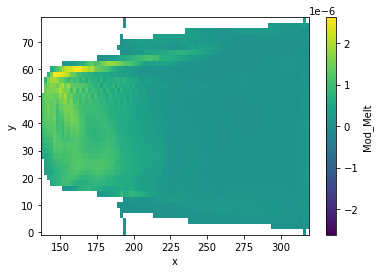

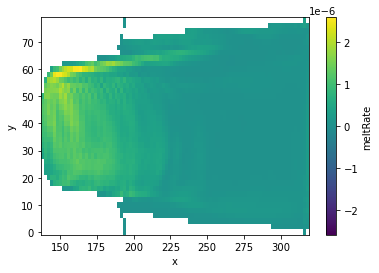

In [12]:
Data = Clean_Data.loc[Clean_Data.date == 190]
X = Data[Var_names_X]
X = np.array((X - mean)/std)
X = np.array(X).reshape(-1, 5, )
Y_mod = Model.model(X)
Data['Mod_Melt'] = Y_mod.numpy().reshape(len(Y_mod, )) * maxY
#Data['Mod_Melt'] = (Y_mod.numpy().reshape(len(Y_mod, )) * stdY) + meanY
Dataset = Data.set_index(['y', 'x'])
Dataset = Dataset.to_xarray()
Dataset.Mod_Melt.plot(cmap = plt.get_cmap('viridis'))
plt.figure()
Dataset.meltRate.plot(cmap = plt.get_cmap('viridis'))

In [13]:
mean.to_pickle(filepath + 'MeanX.pkl')
std.to_pickle(filepath + 'StdX.pkl')
np.savetxt(filepath + 'MaxY.csv', np.array(maxY).reshape(1, ))
tmx = int(Clean_Data.loc[len(Clean_Data) - 1].date)
#STD = pd.read_pickle(pwd + '/std.pkl')

In [16]:
hist = Model.history

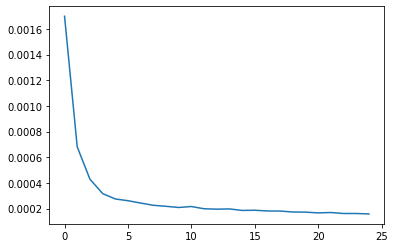

In [22]:
plt.plot(hist['loss'])

In [25]:
hist.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

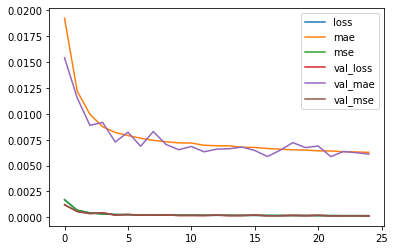

In [33]:
for k in hist.keys():
    plt.plot(hist[k], label = k)
plt.legend()
plt.show()


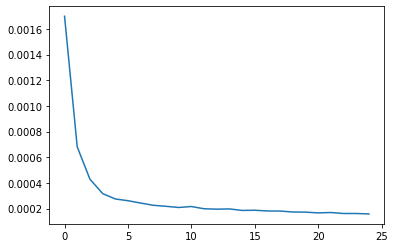

In [34]:
plt.plot(hist['loss'])